In [32]:
import torch as t
import torchmetrics
from DiagnosisAI.utils.metrics import calculate_type_errors, calc_metrics
from DiagnosisAI.models.resnet3d import generate_model
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from torch.utils import data
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nipy
from nibabel.testing import data_path
from tqdm import tqdm
from scipy.ndimage import zoom
from sklearn.cluster import KMeans
import nibabel as nib
from pathlib import Path
from torchvision.transforms import ToTensor
import gc

In [3]:
root_path = Path("../datasets/brain/MICCAI_BraTS2020_ValidationData/")
device = t.device('cpu')
network = generate_model(model_depth=18, n_classes=11, n_input_channels=1)
model_state_path = "../trainings/model_states/classif_3d/resnet18/model_state"
network.load_state_dict(t.load(model_state_path, map_location=device))
embedd_network = nn.Sequential(*list(network.children())[:-1])

embedd_network.eval()
a = 28 / 240
b = 28 / 240
c = 28 / 155

In [4]:
embeddings = []
labels = []
filenames = []

for dir in tqdm(root_path.iterdir(), total=root_path.iterdir().__sizeof__()):
    for filename in dir.iterdir():
        if 'flair' in filename.name:
            label = 0
        if 't1' in filename.name:
            label = 1
        if 't2' in filename.name:
            label = 2
        if 't1ce' in filename.name:
            label = 3
        labels.append(label)
        filenames.append(filename)

        sample = nib.load(filename).get_fdata().copy()
        zoomed_img = zoom(sample,(a, b, c))
        zoomed_img = ToTensor()(zoomed_img).unsqueeze(0).unsqueeze(0)
        with t.no_grad():
            output = embedd_network(zoomed_img.type(t.float32))
        embeddings.append(output.squeeze().numpy())

        del output
        del zoomed_img
        del sample
        gc.collect()

embeddings = np.array(embeddings)
labels = np.array(labels)

125it [05:07,  2.46s/it]                       


In [21]:
t1ce_indicies = np.where(labels == 3)[0]
t1ce_embeddings = embeddings[t1ce_indicies]
t1ce_filenames = [filenames[idx] for idx in t1ce_indicies]

In [38]:
num_feature_dimensions = 100      # Set the number of features
pca = PCA(n_components=num_feature_dimensions)
pca.fit(t1ce_embeddings)
t1ce_compressed = pca.transform(t1ce_embeddings)

In [39]:
neighbors = NearestNeighbors(n_neighbors=len(t1ce_compressed), algorithm='brute', metric='euclidean').fit(t1ce_compressed)

In [40]:
def find_case(filename: str):
    found = False
    founded_path = None
    for dir in root_path.iterdir():
        for filename_path in dir.iterdir():
            if filename == filename_path.name:
                found = True
                sample = nib.load(filename_path).get_fdata().copy()
                break
        if found:
            break
    return sample

In [41]:
input_case = 5
distances, indices = neighbors.kneighbors([t1ce_compressed[input_case]])
indices = indices.flatten()
t1ce_filenames[input_case].name

'BraTS20_Validation_067_t1ce.nii'

In [42]:
k_nearest = indices[0:10]
nearest_dist = distances.flatten()[0:10]
k_furthest = indices[-10:][::-1]
furthest_dist = distances.flatten()[-10:][::-1]

In [43]:
simillar_images = [find_case(t1ce_filenames[idx].name) for idx in k_nearest]
no_simillar_images = [find_case(t1ce_filenames[idx].name) for idx in k_furthest]

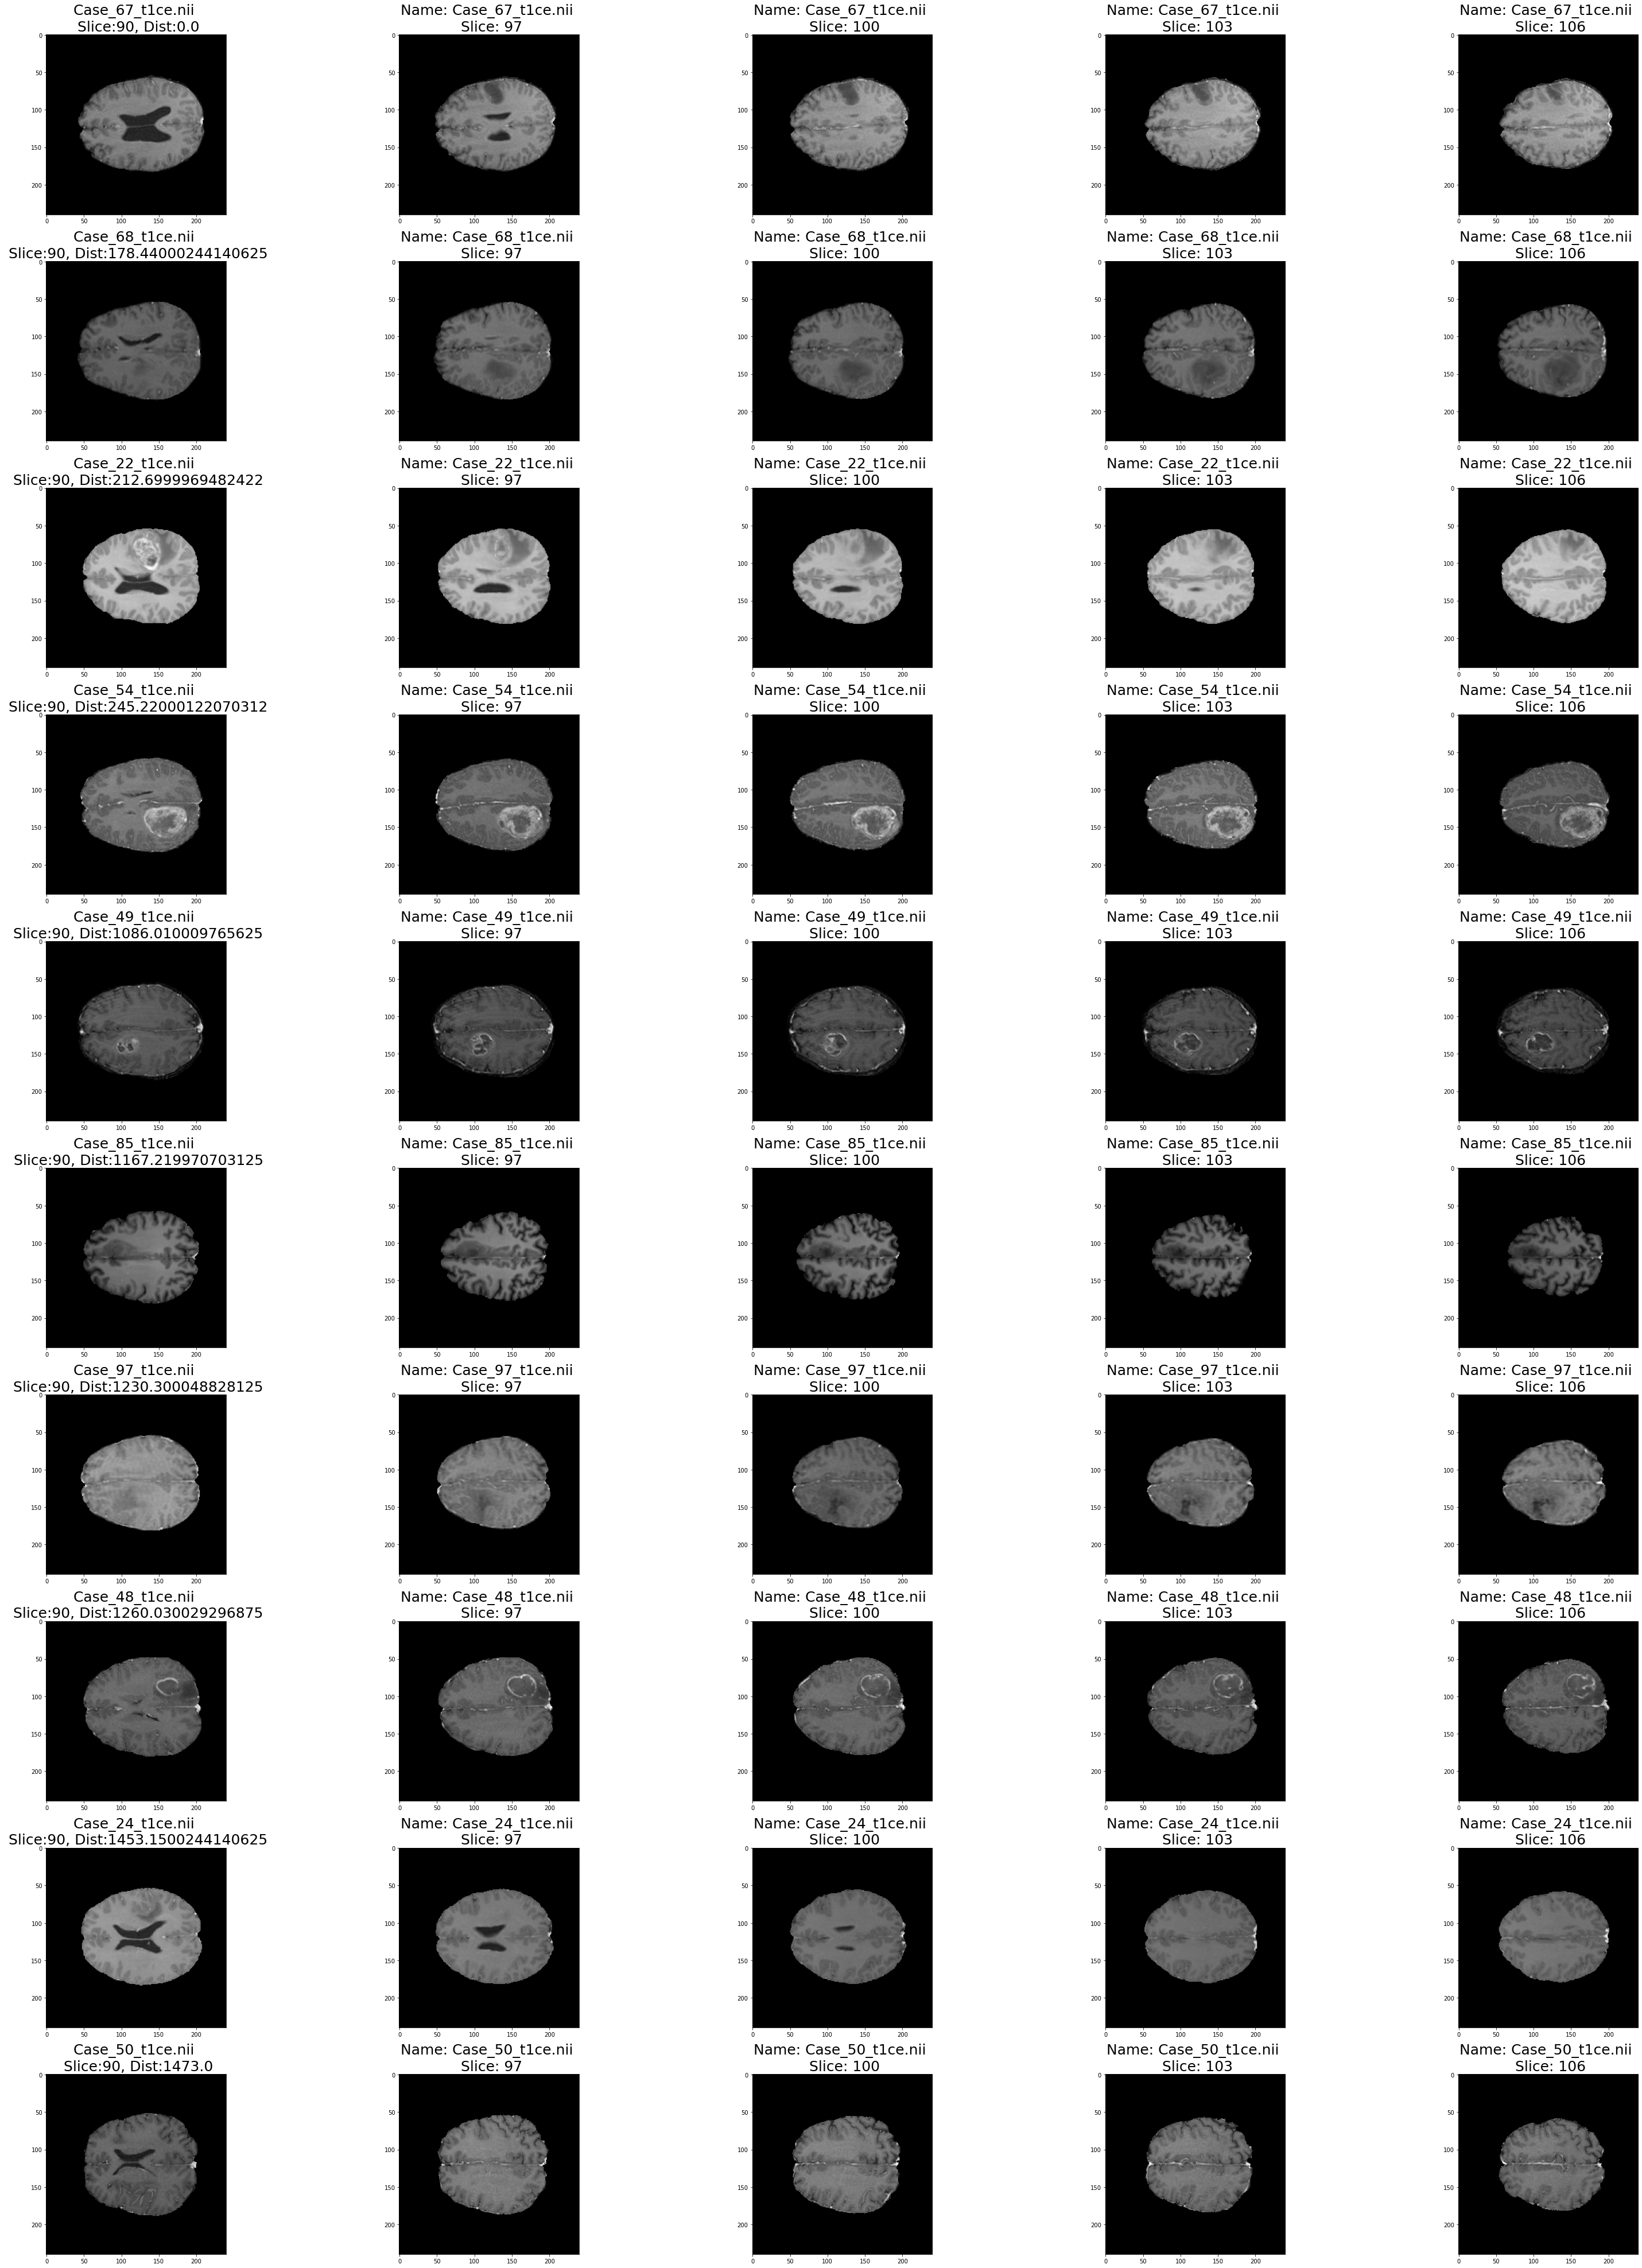

In [44]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(45, 55))
for i, idx in enumerate(k_nearest):
    ax[i, 0].imshow(simillar_images[i][:, :, 90], cmap='gray')
    ax[i][0].set_title(f"{'Case_' + t1ce_filenames[idx].name[20:]} \n Slice:{90}, Dist:{round(nearest_dist[i], 2)}", fontsize=25)
    for j in range(1, 5):
        ax[i, j].imshow(simillar_images[i][:, :, 94 + 3*j], cmap='gray')
        ax[i, j].set_title(f"Name: {'Case_' + t1ce_filenames[idx].name[20:]} \n Slice: {94 + 3*j}", fontsize=25)
fig.tight_layout()


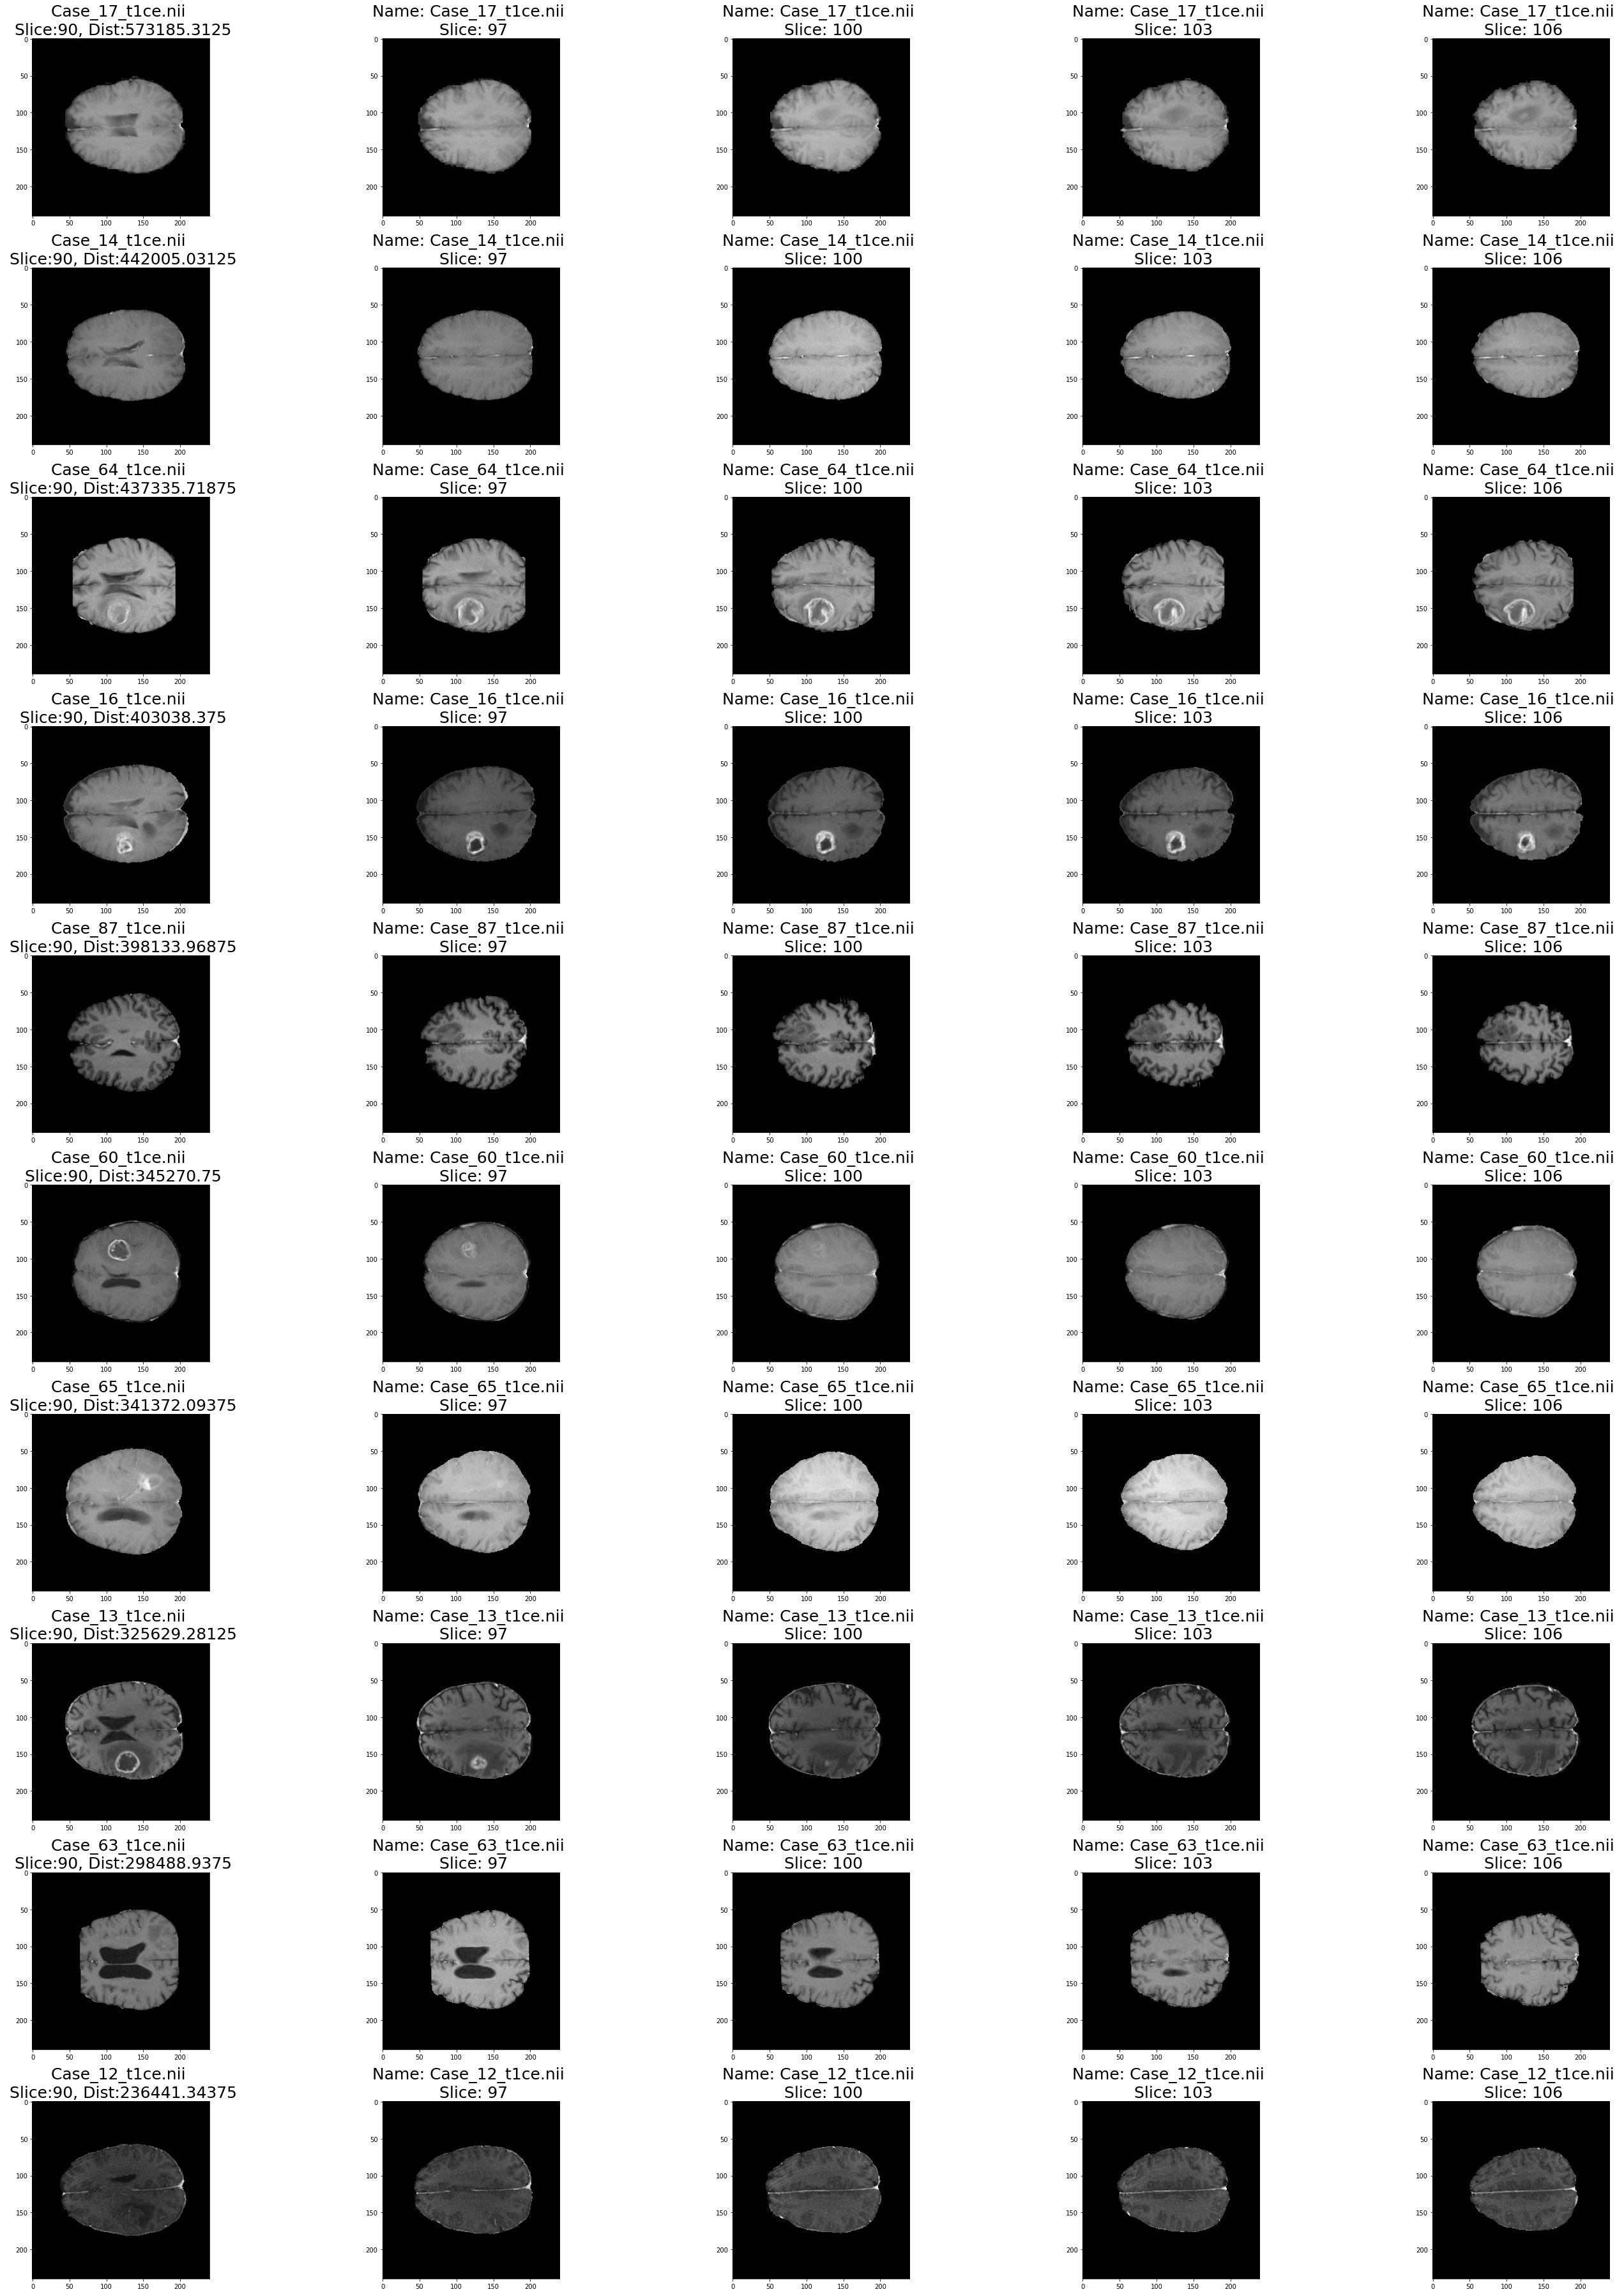

In [45]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(40, 50))
for i, idx in enumerate(k_furthest):
    ax[i, 0].imshow(no_simillar_images[i][:, :, 90], cmap='gray')
    ax[i][0].set_title(f"{'Case_' + t1ce_filenames[idx].name[20:]} \n Slice:{90}, Dist:{round(furthest_dist[i], 2)}", fontsize=25)
    for j in range(1, 5):
        ax[i, j].imshow(no_simillar_images[i][:, :, 94 + 3*j], cmap='gray')
        ax[i, j].set_title(f"Name: {'Case_' + t1ce_filenames[idx].name[20:]} \n Slice: {94 + 3*j}", fontsize=25)
fig.tight_layout()

/Users/michalnt/miniconda3/envs/typical_deeplearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/michalnt/miniconda3/envs/typical_deeplearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 125 samples in 0.000s...
[t-SNE] Computed neighbors for 125 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 125 / 125
[t-SNE] Mean sigma: 3463.767361
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.445198
[t-SNE] KL divergence after 850 iterations: 0.047055


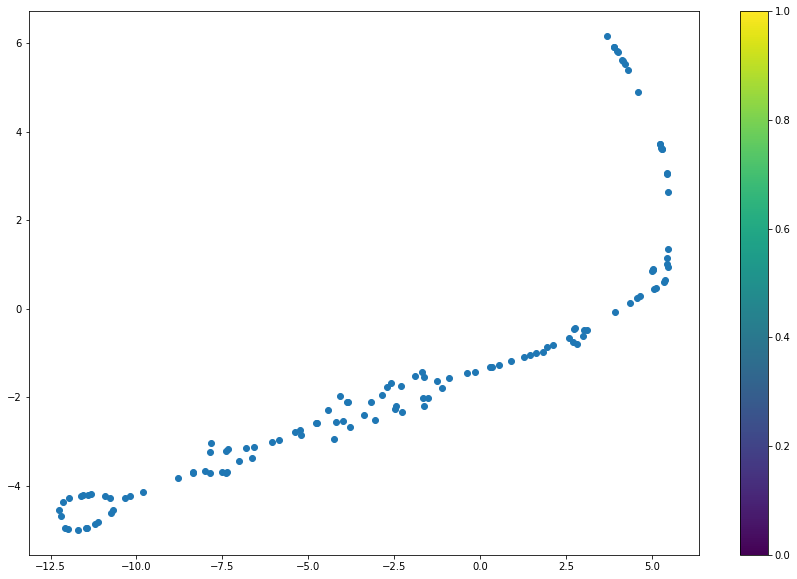

In [46]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(t1ce_embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

In [47]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(t1ce_embeddings)

In [48]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 3, 1, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)